<a href="https://colab.research.google.com/github/masadeghi/EHRsample/blob/main/linear_regression_svm_random_forest_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import dependencies**

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import mean_squared_error

# **Import data**

1. Download the data from this link (You'll need to sign up in the PhysioNet website and sign a data use agreement.'): https://physionet.org/content/heart-failure-zigong/1.3/#files
2. Upload the .zip file to your google drive. (Here, I've uploaded the file to a folder named "databases" in my Google drive)
3. Read the datasets into pandas dataframes.

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip the .zip file containing all the datasets
!unzip gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip

Archive:  gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/LICENSE.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/SHA256SUMS.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv  


In [3]:
# Read the datasets into pandas dataframes
patient_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv', index_col = 0)
treatment_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv', index_col = 0)
dict_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv', index_col = 0)

# **Exploratory data analysis and feature engineering**

## Step 1: Restructure the treatment data
One-hot encode the `treatment_data` dataset so that treatment data (drugs administered to the patients during their hospitalization) could be concatenated with the clinical and lab data (`patient_data` dataset).

In [4]:
# Initialize zeros matrix with desired dimensions, indexes, and column names
drugs = np.zeros((len(patient_data['inpatient.number'].unique()),
                  len(treatment_data['Drug_name'].unique())))

drugs = pd.DataFrame(drugs, index = patient_data['inpatient.number'].unique(), columns = treatment_data['Drug_name'].unique())

# Iterate over the rows and columns of the constructed matrix and repalce 0 with 1
# in the appropriate column if the treatment was administered.
for index, row in drugs.iterrows():
  for col in drugs.columns:
    subset = treatment_data.loc[treatment_data['inpatient.number'] == index, 'Drug_name']
    if col in subset.values:
      drugs.loc[index, col] = 1

# Concatenate the resulting matrix with the main dataset:
# Total data (t_data) = main dataset + drug data
patient_data.set_index('inpatient.number', inplace = True)

t_data = pd.concat([patient_data, drugs], axis = 1)

## Step 2: Explore the features

* Identify features with missing data.
* Explore each feature to understand its data structure.

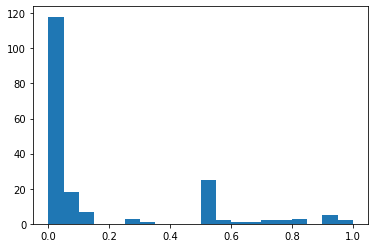

In [5]:
# Determining the extent of missing data in the dataset
missing_perc = []

for i, col in enumerate(t_data.columns):
  percentage = t_data[col].isnull().mean()
  missing_perc.append((i, col, percentage))

missing_perc.sort(key = lambda x: x[2], reverse = True)

plt.hist([i[2] for i in missing_perc], bins = 20)
plt.show()

In [6]:
# Explore each variable
def summary(colname):
  col = t_data[colname]

  print(col[:5])

  if col.dtype == object:
    print('\n Unique factors: \n', col.unique())
    print('\n', col.describe(include = 'object'))
  else:
    print('\n', col.describe())

summary("dischargeDay")

857781    11
743087     8
866418     5
775928    11
810128     5
Name: dischargeDay, dtype: int64

 count    2008.000000
mean        9.420817
std         8.030256
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max       123.000000
Name: dischargeDay, dtype: float64


## Step 3: Split data into predictor (`X`) and target (`y`) datasets
* Log transform `y` to make it's distribution closer to normal.

In [7]:
y = t_data['dischargeDay']
X = t_data.drop('dischargeDay', axis = 1)

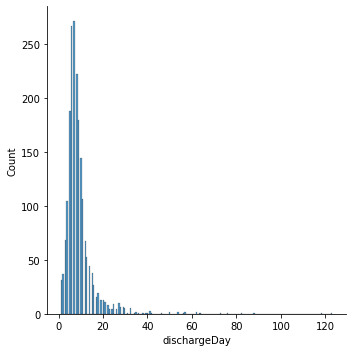

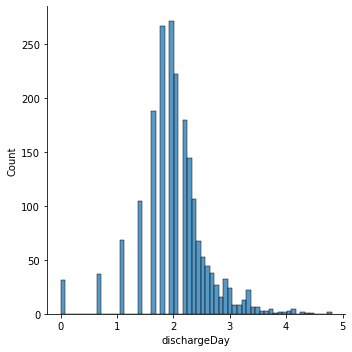

In [8]:
# log transform y
import seaborn as sns
sns.displot(y)
y = np.log(y)
sns.displot(y)

## Step 4: Remove features that aren't useful in a practical setting
Explore the features in `X` to classify them into the following categories:

*   Features that are expected to be available at the time of admission or a short while after (e.g., preliminary lab data)
*   Features that are expected to be available only at the time of discharge
*   Features from echocardiography
*   Features that are expected to be available only after patient discharge and on patient follow-up

For predicting duration of hospital stay, only the first category could be useful in a clinical setting.

In [9]:
# Features only availble at the time of discharge
discharge_var = ['DestinationDischarge', 'discharge.department', 'outcome.during.hospitalization']

# Features only available after discharge and on patient follow-up
future_var = ['death.within.28.days', 're.admission.within.28.days', 'death.within.3.months',
              're.admission.within.3.months', 'death.within.6.months', 're.admission.within.6.months',
              'time.of.death..days.from.admission.', 're.admission.time..days.from.admission.',
              'return.to.emergency.department.within.6.months', 'time.to.emergency.department.within.6.months']

# Features only available after an echocardiography
echo_var = ['LVEF', 'left.ventricular.end.diastolic.diameter.LV',
            'mitral.valve.EMS', 'mitral.valve.AMS', 'EA',
            'tricuspid.valve.return.velocity', 'tricuspid.valve.return.pressure']

# Remove future_var and discharge_var from X
X = X.drop(discharge_var + future_var, axis = 1)

## Step 5: Remove features with too many missing values

In [10]:
# Remove features with more than 20% missing data
keepers = [True] * len(X.columns)

for i, col in enumerate(X.columns):
  if X[col].isnull().mean() > 0.2: # This also removes all echo_vars
    keepers[i] = False

X = X.loc[:, keepers]

## Step 6: Convert ordered categorical features to numerical encodings
e.g., NYHA classification could be represented as 1.0 to 4.0 to indicate increasing severity of heart failure.

In [11]:
convert_ordered = {'NYHA.cardiac.function.classification': {'II': 2, 'III': 3, 'IV': 4},
                   'Killip.grade': {'I': 1, 'II': 2, 'III': 3, 'IV': 4},
                   'consciousness': {'Clear': 0, 'ResponsiveToSound': 1, 'ResponsiveToPain': 2, 'Nonresponsive': 3},
                   'respiratory.support.': {'None': 0, 'NIMV': 1, 'IMV': 2},
                   'ageCat': {'(21,29]': 0, '(29,39]': 1, '(39,49]': 2, '(49,59]': 3, '(59,69]': 4, '(69,79]': 5, '(79,89]': 6, '(89,110]': 7},
                   'oxygen.inhalation': {'AmbientAir': 0, 'OxygenTherapy': 1},
                   'type.II.respiratory.failure': {'NonTypeII': 0, 'TypeII': 1}
}

X = X.replace(convert_ordered)

## Step 7: One-hot encode non-ordered categorical features

In [12]:
non_ordered_cat_features = ['admission.ward', 'admission.way', 'occupation', 'gender', 'type.of.heart.failure']

# Replace NAs with most frequent value in the categorical columns.
# Occupation is the only categorical feature with missing values
value = X['occupation'].mode()[0]
X['occupation'].replace(np.nan, value, inplace = True)

# OneHotencoding
X_obj = X[non_ordered_cat_features]
enc = OneHotEncoder(sparse = False) #sparse = False to enable concatenation with the noncategorical variables.
X_obj_enc = enc.fit_transform(X_obj)
X_obj_enc = pd.DataFrame(X_obj_enc, columns = enc.get_feature_names_out(), index = X.index)

#Replace object variables with the onehot encoded version in the original dataset
X.drop(X_obj.columns,
       axis = 1,
       inplace = True)

X = pd.concat([X_obj_enc, X], axis = 1)

# **Prepare data for input into models**

## Step 1: Split into train/test datasets

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Step 2: Impute missing values using the KNN imputer

In [14]:
imp = KNNImputer()

X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

## Step 3: Normalize data
* Standard scaling can also be used. However, in my experiments, MinMaxScaling performed better than StandardScaling, possibly due to the high number of one-hot-encoded features in the dataset.

In [15]:
scaler = MinMaxScaler()

X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# **Build regularized linear regression model for prediction of hospitalization duration**

In [16]:
# Suppress convergence warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

lin_reg = ElasticNetCV(l1_ratio = [0, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99, 1],
                       alphas = [0, 0.1, 0.2, 0.5, 0.7, 0.9, 1])

lin_reg.fit(X_train_minmax, y_train)
y_pred = lin_reg.predict(X_test_minmax)
lin_reg_result =  mean_squared_error(y_test, y_pred)

print('\nMSE for lin_reg is: ', lin_reg_result)
print('\nChosen l1-ratio: ', lin_reg.l1_ratio_)
print('\nChosen alpha: ', lin_reg.alpha_)


MSE for lin_reg is:  0.2668101254502268

Chosen l1-ratio:  0.0

Chosen alpha:  0.1


# **Build support vector regressor for prediction of hospitalization duration**

In [24]:
sv_reg = SVR()

random_grid = {'kernel': ['rbf'], #I didn't add the 'linear' kernel to save computational time.
               'gamma': [x for x in np.linspace(start = 0.5, stop = 5, num = 10)],
               'C': [x for x in np.linspace(start = 0.1, stop = 10, num = 10)]}

sv_reg = RandomizedSearchCV(estimator = sv_reg, param_distributions = random_grid, 
                             cv = 3, verbose = 3, n_jobs = -1, random_state = 42,
                             scoring = 'neg_mean_squared_error')


sv_reg.fit(X_train, y_train)

print('\nBest estimator: \n', sv_reg.best_estimator_)
print('\nBest score: \n', sv_reg.best_score_)
print('\nBest parameters: \n', sv_reg.best_params_)

y_pred = sv_reg.best_estimator_.predict(X_test)

svm_reg_result = mean_squared_error(y_test, y_pred)

print('\nMSE on test data: ', svm_reg_result)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best estimator: 
 SVR(C=8.9, gamma=2.0)

Best score: 
 -0.3690139331649358

Best parameters: 
 {'kernel': 'rbf', 'gamma': 2.0, 'C': 8.9}

MSE on test data:  0.3243721573136629


# **Build random forest model for prediction of hospitalization duration**

In [18]:
tuned_rnd_reg = RandomForestRegressor()

max_depth = [int(x) for x in np.linspace(3, 110, num = 11)]
max_depth.append(None)

random_grid = {'max_depth': max_depth,
               'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['sqrt', 'auto']}

tuned_rnd_reg = RandomizedSearchCV(estimator = tuned_rnd_reg, param_distributions = random_grid, 
                             cv = 3, verbose = 3, n_jobs = -1, random_state = 42,
                             scoring = 'neg_mean_squared_error')

tuned_rnd_reg.fit(X_train, y_train)

print('\nBest estimator \n', tuned_rnd_reg.best_estimator_)
print('\nBest score \n', tuned_rnd_reg.best_score_)
print('\nBest parameters \n', tuned_rnd_reg.best_params_)

y_pred = tuned_rnd_reg.best_estimator_.predict(X_test)

tuned_rnd_reg_result = mean_squared_error(y_test, y_pred)

print('\nMSE on test data:', tuned_rnd_reg_result)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best estimator 
 RandomForestRegressor(max_depth=45, n_estimators=800)

Best score 
 -0.2984132714580838

Best parameters 
 {'n_estimators': 800, 'max_features': 'auto', 'max_depth': 45}

MSE on test data: 0.25917336914434164


## Step 3: Extract feature importances

In [22]:
forest_importance = pd.Series(tuned_rnd_reg.best_estimator_.feature_importances_,
                              index = X.columns).sort_values(ascending = False)

forest_importance[:10]

Torasemide tablet                  0.036603
Furosemide tablet                  0.035096
carbon.dioxide.binding.capacity    0.025971
cystatin                           0.024288
creatine.kinase.isoenzyme          0.022538
uric.acid                          0.020454
chloride                           0.018294
urea                               0.017705
alkaline.phosphatase               0.017612
platelet                           0.017280
dtype: float64

# **Build super ensemble (voting regressor) model**

In [27]:
vote_reg = VotingRegressor(estimators = [('rf', tuned_rnd_reg.best_estimator_), ('lin', lin_reg), ('svr', sv_reg)])

vote_reg.fit(X_train_minmax, y_train)

y_pred = vote_reg.predict(X_test_minmax)

vote_reg_result = mean_squared_error(y_test, y_pred)

print('\nMSE for vote_reg is: ', vote_reg_result)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

MSE for vote_reg is:  0.2584857464298306


# **Conclusion**

In [28]:
print('MSE on test data:')
print(f'Regularized inear regression: {lin_reg_result:8.4f}')
print(f'SVM regression: {svm_reg_result:8.4f}')
print(f'Random forest regression: {tuned_rnd_reg_result:8.4f}')
print(f'Super ensemble voting regression: {vote_reg_result:8.4f}')

MSE on test data:
Regularized inear regression:   0.2668
SVM regression:   0.3244
Random forest regression:   0.2592
Super ensemble voting regression:   0.2585
